In [75]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit.visualization import plot_histogram

In [303]:
# Implementing the Oracle for the Grovers Algorithm using auxiliary qubit

def Oracle(bin_index, array_length):
    qr = QuantumRegister(array_length)
    oracle_reg = QuantumRegister(1)
    qc = QuantumCircuit(qr, oracle_reg, name="Oracle")
    bin_index = bin_index.rjust(array_length, '0')
    for i in range(array_length):
        if (bin_index[i] == '0'):
            qc.x(qr[i])
    qc.mct(qr[:], oracle_reg)
    for i in range(array_length):
        if (bin_index[i] == '0'):
            qc.x(qr[i])
    return qc

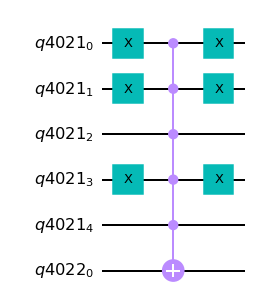

In [304]:
qc = Oracle('101', 5)
qc.draw('mpl')

In [258]:
# Implementing Diffuser Circuit

def Diffuser(number):
    qr = QuantumRegister(number)
    qc = QuantumCircuit(qr,  name="Diffuser")
    qc.h(qr[:])
    qc.x(qr[:])
    qc.h(qr[number-1])
    qc.mct(qr[0:number-1], qr[number-1])
    qc.h(qr[number-1])
    qc.x(qr[:])
    qc.h(qr[:])

    return qc

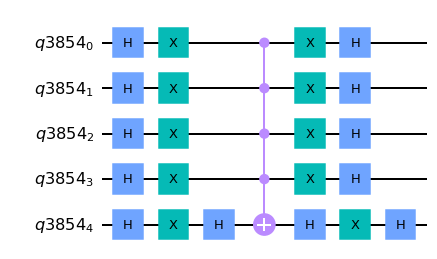

In [259]:
qc = Diffuser(5)
qc.draw('mpl')

In [331]:
def Grover_Search(index, array_length):
    bin_index = str(bin(index))[2:]
    if (len(bin_index) > array_length):
        print("Index out of Range!")
        return None    
    qr = QuantumRegister(array_length)
    oracle_reg = QuantumRegister(1)
    cr = ClassicalRegister(array_length)
    qc = QuantumCircuit(qr, oracle_reg,  cr)
    
    qc.h(qr[:])
    qc.x(oracle_reg)
    qc.h(oracle_reg)
    qc.barrier()
    
    loop_range = int(np.pi/4 * (np.sqrt(2**array_length)))
    
    for i in range(loop_range):
        qc.append(Oracle(bin_index, array_length), qr[:] + oracle_reg[:])
        qc.barrier()
        qc.append(Diffuser(array_length), qr[:])
        qc.barrier()
    qc.h(oracle_reg)
    qc.x(oracle_reg)
    
    qc.barrier()
    
    qc.measure(qr, cr)
    return qc


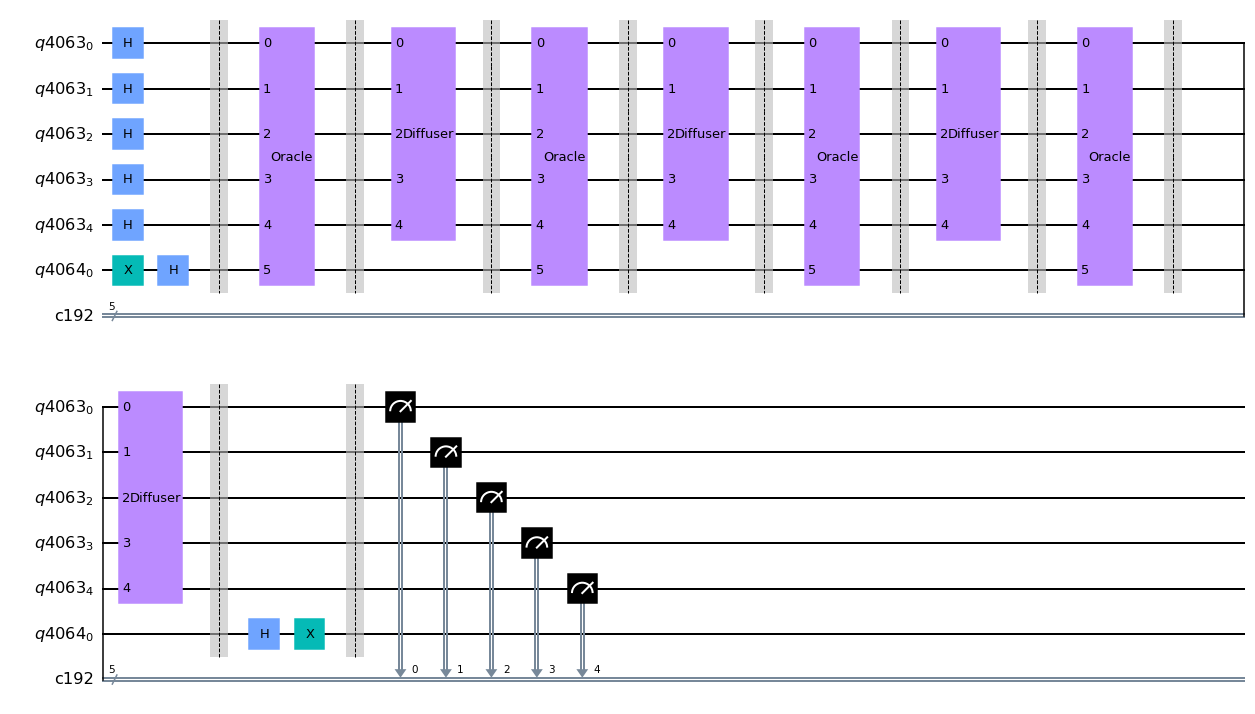

In [332]:
qc = Grover_Search(5, 5)
qc.draw('mpl')

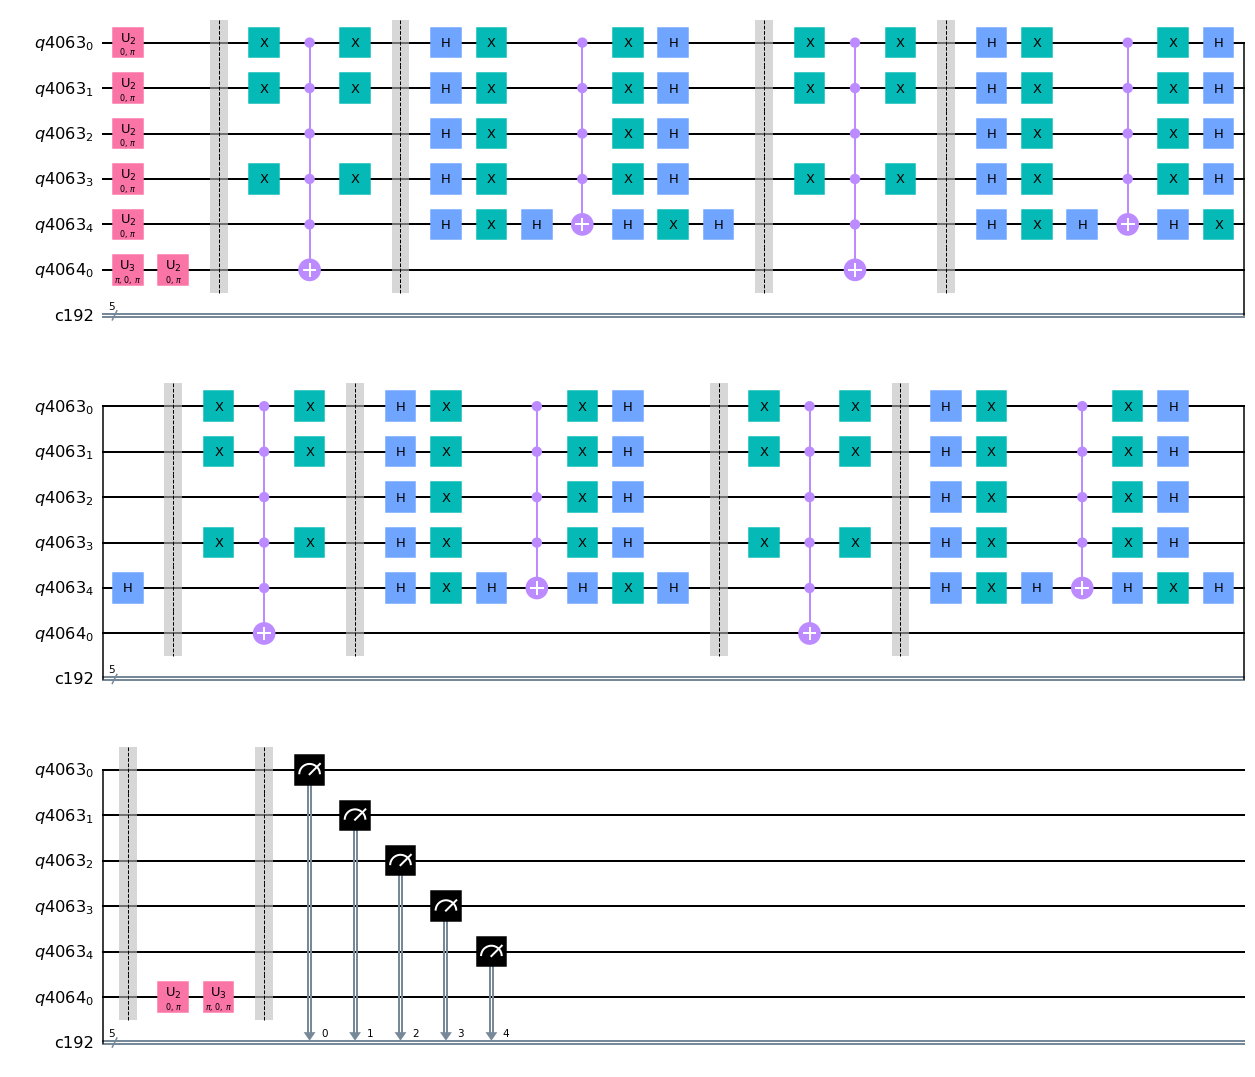

In [333]:
qc.decompose().draw('mpl')

In [364]:
# Executing this Circuit 

backend = Aer.get_backend('qasm_simulator')

qc = Grover_Search(5, 5)
qc = qc.reverse_bits()
results = execute(qc, backend, shots=1024).result()
count = results.get_counts()


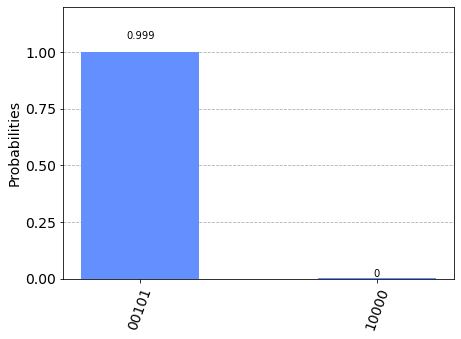

In [335]:
plot_histogram(count)

In [357]:
# Finding the Cost of this Quantum Circuit

from qiskit.quantum_info import Pauli, state_fidelity, process_fidelity, Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit import transpile

In [337]:
qc.count_ops()

OrderedDict([('barrier', 10),
             ('h', 7),
             ('measure', 5),
             ('Oracle', 4),
             ('Diffuser', 4),
             ('x', 2)])

# Decomposing this circuit to find the number of gates

In [365]:
result = transpile(qc, backend=backend, basis_gates=['u3', 'cx'], optimization_level=3)

In [366]:
result_dict = result.count_ops()

In [367]:
print("Total Cost:", (result_dict['u3'] + result_dict['cx']*10))

Total Cost: 6059


# Another Implementation Of Grovers Algorithm for Unstructured Search problem Using Unitary Matrix


In [329]:
# Implementation for Phase Oracle 
def phase_oracle(n, index):
    qc = QuantumCircuit(n, name="ORACLE")
    oracle_matrix = np.identity(2**n) # Identity Matrix to create the oracle 
    for idx in index:
        oracle_matrix[idx, idx] = -1 # Marking the indices for phase inversion
    # Converting this matrix into unitary operator
    qc.unitary(Operator(oracle_matrix), range(n))

    return qc
        

In [330]:
# Creating diffuser
def diffuser(n):
    qc = QuantumCircuit(n, name="DIFFUSER")
    qc.h(range(n))
    qc.append(phase_oracle(n, [0]), range(n)) # Diffuser being the diagonal matrix with first index marked -1
    qc.h(range(n))
    return qc

In [341]:
# Implementing Grover
def Grover(n, indexes):
    qc = QuantumCircuit(n, n)
    r = int(np.floor(np.pi/4 * np.sqrt(2**n/len(indexes)))) # number of loops to run 
    
    qc.h(range(n))
    
    for i in range(r):
        qc.append(phase_oracle(n, indexes), range(n))
        qc.barrier()
        qc.append(diffuser(n), range(n))
        qc.barrier()
    qc.measure(range(n), range(n))
    return qc

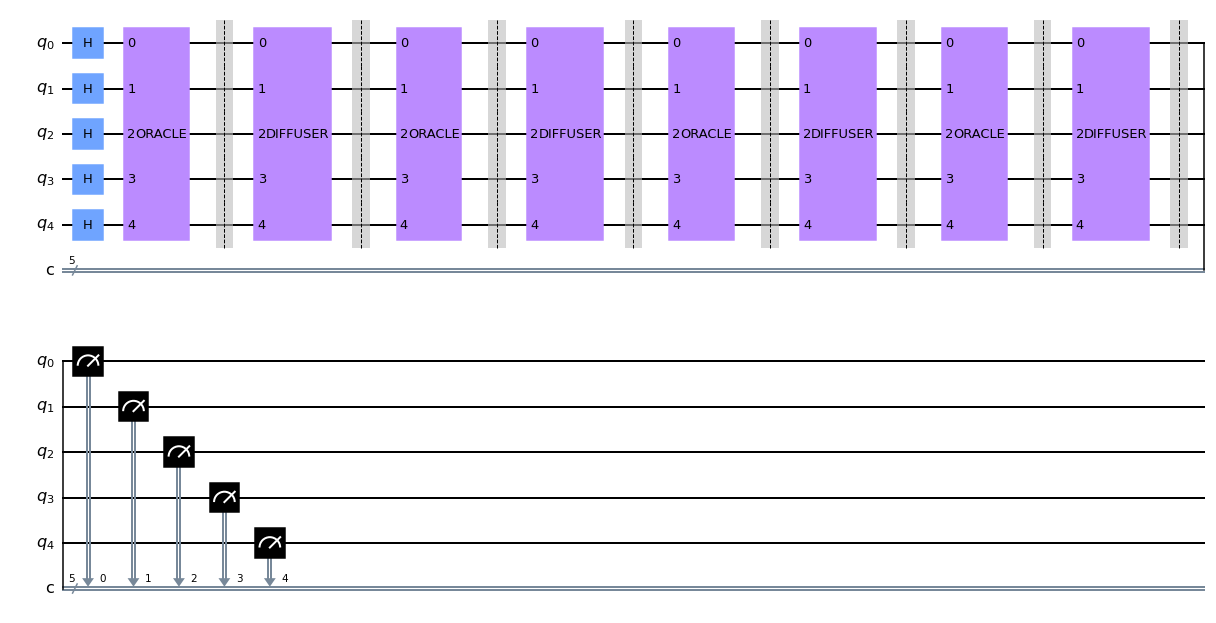

In [346]:
qc = Grover(5, [5])
qc.draw('mpl')

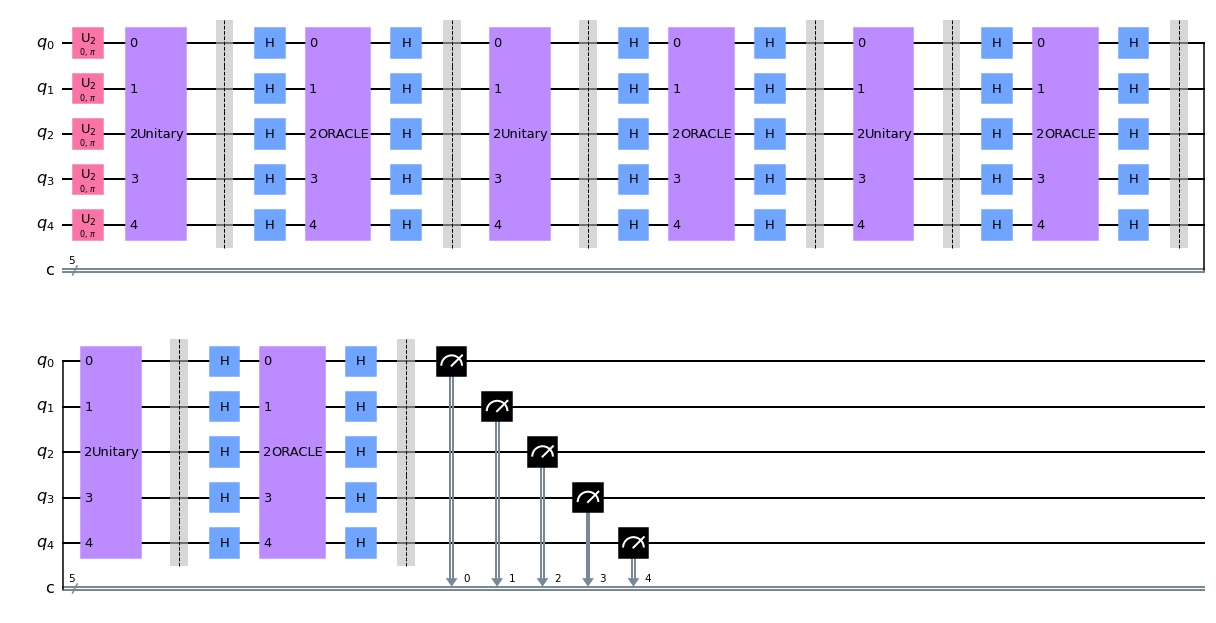

In [347]:
qc.decompose().draw('mpl')

In [371]:
# Executing this Circuit 

backend = Aer.get_backend('qasm_simulator')

qc = Grover(5, [5])
qc = qc.reverse_bits()
results = execute(qc, backend, shots=1024).result()
count = results.get_counts()

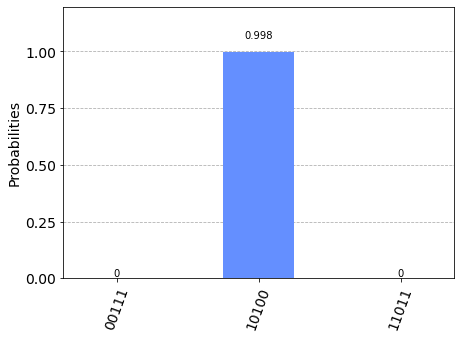

In [349]:
plot_histogram(count)

In [351]:
qc.count_ops()

OrderedDict([('barrier', 8),
             ('h', 5),
             ('measure', 5),
             ('ORACLE', 4),
             ('DIFFUSER', 4)])

In [372]:
result = transpile(qc, backend=backend, basis_gates=['u3', 'cx'], optimization_level=3)

In [373]:
result_dict = result.count_ops()

In [374]:
print("Total Cost:", (result_dict['u3'] + result_dict['cx']*10))

Total Cost: 2688


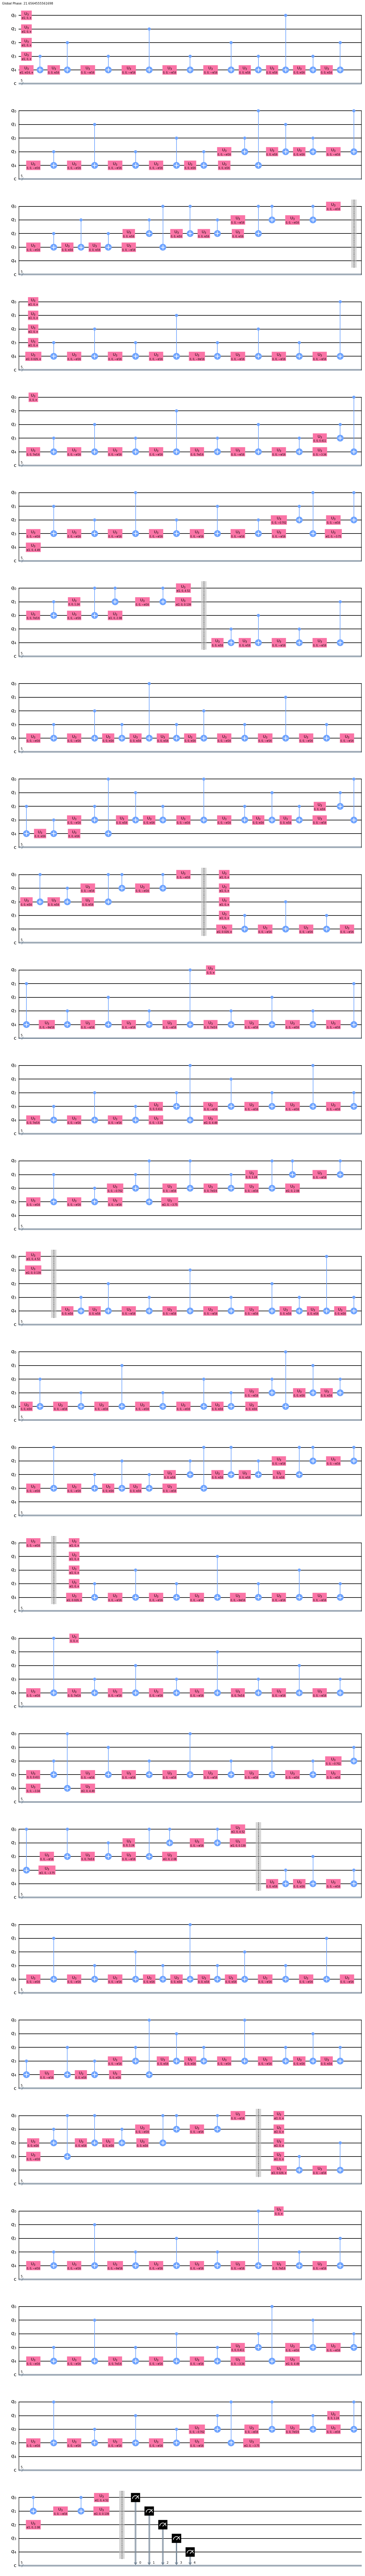

In [375]:
result.draw('mpl')